<a href="https://colab.research.google.com/github/daspartho/bored-ape-diffusion/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Installing required libraries

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

     |████████████████████████████████| 453 kB 19.0 MB/s 
     |████████████████████████████████| 451 kB 56.0 MB/s 
     |████████████████████████████████| 5.8 MB 48.7 MB/s 
     |████████████████████████████████| 191 kB 66.0 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 36.0 MB 57 kB/s 
     |████████████████████████████████| 182 kB 52.4 MB/s 
     |████████████████████████████████| 132 kB 71.9 MB/s 
     |████████████████████████████████| 212 kB 67.8 MB/s 
     |████████████████████████████████| 127 kB 56.7 MB/s 
     |████████████████████████████████| 7.6 MB 48.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.1 which is incompatible.
db-dtypes 1.0.4 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.1 which is 

Installing Git-LFS to upload your model checkpoints

In [2]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

Define convenience functions

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from PIL import Image

def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download training dataset

We'll be downloading [this collection of 10000 Bored Apes](https://huggingface.co/datasets/daspartho/bored-ape) i've uploaded on HF Hub :)

In [4]:
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("daspartho/bored-ape", split="train")

image_size = 64

batch_size = 64

# Define data transformations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/daspartho___parquet/daspartho--bored-ape-e5adc902b844de1c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Let's grab a batch of images and view some of them

X shape: torch.Size([8, 3, 64, 64])


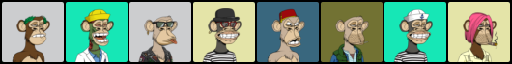

In [5]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

### Noise Scheduler

Defining a noise scheduler with 'cosine' schedule, which may be better for small image sizes

In [6]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps

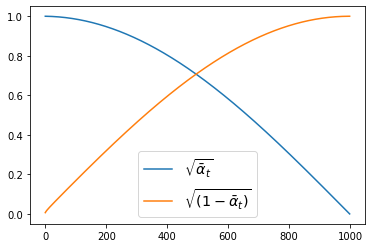

In [7]:
import matplotlib.pyplot as plt

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

we can now use the noise scheduler to add noise in different amounts using the noise_scheduler.add_noise function like so

Noisy X shape torch.Size([8, 3, 64, 64])


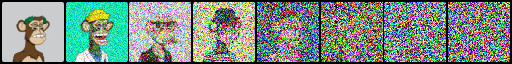

In [8]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

### Define the Model

Let's create a U-net for our desired image size using the handy UNet2DModel class which Diffusers provides that creates the desired architecture in PyTorch

In [9]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

Let's pass in a batch of data and some random timesteps through the model and produces an output the same shape as the input data

In [10]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 64, 64])

### Training Loop

A minimal training loop

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(20):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:1, loss: 0.14032686373610406
Epoch:2, loss: 0.07494249534170339
Epoch:3, loss: 0.05690267831561672
Epoch:4, loss: 0.04720293348477145
Epoch:5, loss: 0.04005653165565554
Epoch:6, loss: 0.03710380664012235
Epoch:7, loss: 0.0326306944368941
Epoch:8, loss: 0.02801479410475037
Epoch:9, loss: 0.026851495099105654
Epoch:10, loss: 0.02375918933469209
Epoch:11, loss: 0.024341612555988275
Epoch:12, loss: 0.0215647898341535
Epoch:13, loss: 0.020122374224055346
Epoch:14, loss: 0.01875028107908501
Epoch:15, loss: 0.02002343845666404
Epoch:16, loss: 0.01742931737143333
Epoch:17, loss: 0.01753757232028967
Epoch:18, loss: 0.01648577350743447
Epoch:19, loss: 0.017952318534634675
Epoch:20, loss: 0.01664763518199799


Plotting the loss

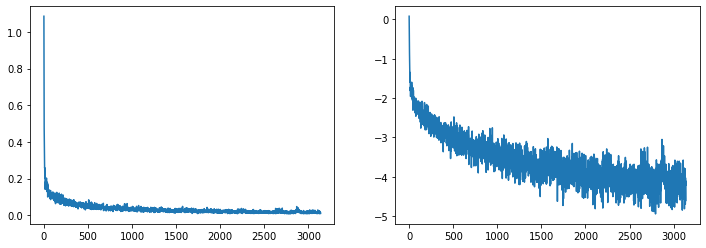

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### Generating Images

#### Option 1: Create pipeline

In [13]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

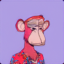

In [14]:
pipeline_output = image_pipe()
pipeline_output.images[0]

save the pipeline to a local folder

In [15]:
image_pipe.save_pretrained("bored-ape-diffusion")

Inspecting the folder contents

In [16]:
!ls bored-ape-diffusion/

model_index.json  scheduler  unet


In [17]:
!ls bored-ape-diffusion/unet/

config.json  diffusion_pytorch_model.bin


#### Option 2: Writing a Sampling Loop

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction

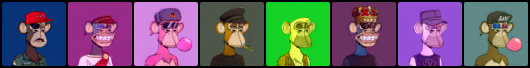

In [18]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 64, 64).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

### Push model to HF Hub

Login with an access token with write permission

In [19]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


Getting the repository name

In [20]:
from huggingface_hub import get_full_repo_name

model_name = "bored-ape-diffusion"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'daspartho/bored-ape-diffusion'

Create a model repository on the 🤗 Hub and push our model

In [21]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id, exist_ok=True)
api = HfApi()
api.upload_folder(
    folder_path="bored-ape-diffusion/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="bored-ape-diffusion/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="bored-ape-diffusion/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/daspartho/bored-ape-diffusion/blob/main/model_index.json'

Let's download the model from Hub and try generating some Bored Apes

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

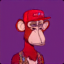

In [22]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id).to(device)
pipeline_output = image_pipe()
pipeline_output.images[0]